In [1]:
import os
os.chdir('..')  #cd to project folder

import pandas as pd
from Bio import Phylo
import yaml
import numpy as np
from pathlib import Path
import logging
from src.utils import load_config
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

Import data

In [ ]:
#import config
config = load_config(path='config/config.yaml', section='wikidata')

#import data
tree_file_path = Path(config['tree_file'])
tree = Phylo.read(tree_file_path, 'newick')
scaffold_list = config['scaffolds'] #scaffold list

#import cleaned sparql results, concatenate into single df
scaffold_df = []
for scaffold, path in config['sparql_results_clean'].items():
    df = pd.read_csv(path)
    df['Scaffold'] = scaffold
    scaffold_df.append(df)
scaffold_df = pd.concat(scaffold_df, ignore_index=True)

INFO: Angiosperms phylogenetic tree successfully imported!


Convert phylogenetic tree into data table (`Order`, `Family`, `Genus`, `Species`) and add binary columns for each scaffold (0: not reported in genus; 1:reported in genus)

In [14]:
#extract leaf names
tree_leaves = [leaf.name for leaf in tree.get_terminals()]
tree_leaves = pd.Series(tree_leaves, name='leaf_name')
logging.info(f'Tree contains {len(tree_leaves)} leaves')
logging.info(f"{tree_leaves.str.endswith('sp.').sum()} species names are not defined in the tree (e.g., 'Lessertia_sp.')")

#create df with order, family, genus, species
tree_df = tree_leaves.str.split('_', expand=True)
tree_df = tree_df.iloc[:, :4] #keep first 4 columns
tree_df.columns = ['Order', 'Family', 'Genus', 'Species']
tree_df = pd.concat([tree_leaves, tree_df], axis=1).rename(columns={0: 'leaf_name'}).set_index('leaf_name')

#add binary column for each scaffold
for s in scaffold_list:
    tree_df[s] = 0  #create zero column
    genera_list = scaffold_df[scaffold_df['Scaffold'] == s]['genus_name'].unique() #list of genera with report (for each scaffold)
    logging.info(f"{s} scaffold reported in {len(genera_list)} genera based on Wikiedata")

    #if genus with report present in the tree, set to 1
    for g in genera_list:
        tree_df.loc[tree_df['Genus'] == g, s] = 1  

#print
tree_df.head(n=5)

INFO: Tree contains 7922 leaves
INFO: 293 species names are not defined in the tree (e.g., 'Lessertia_sp.')
INFO: benzylisoquinoline scaffold reported in 293 genera based on Wikiedata
INFO: aporphine scaffold reported in 191 genera based on Wikiedata
INFO: piperolactam scaffold reported in 19 genera based on Wikiedata
INFO: piperidine scaffold reported in 6 genera based on Wikiedata
INFO: seco-bia scaffold reported in 1 genera based on Wikiedata


,Order,Family,Genus,Species,benzylisoquinoline,aporphine,piperolactam,piperidine,seco-bia
leaf_name,,,,,,,,,
Poales_Poaceae_Neostapfia_colusana,Poales,Poaceae,Neostapfia,colusana,0,0,0,0,0
Poales_Poaceae_Orcuttia_tenuis,Poales,Poaceae,Orcuttia,tenuis,0,0,0,0,0
Poales_Poaceae_Orinus_thoroldii,Poales,Poaceae,Orinus,thoroldii,0,0,0,0,0
Poales_Poaceae_Tridentopsis_mutica,Poales,Poaceae,Tridentopsis,mutica,0,0,0,0,0
Poales_Poaceae_Gouinia_latifolia,Poales,Poaceae,Gouinia,latifolia,0,0,0,0,0


Correct data based on manual inspection

In [ ]:
# #manual fixes
# tree_df.loc['Piperales_Piperaceae_Piper_nigrum', 'seco-bia'] = 1 #seco-bia scaffold in Piper (present study)
# tree_df.loc['Solanales_Solanaceae_Capsicum_annuum', 'piperidine'] = 0 #error in Wikidata for pieperine in Capsicumannuum
# tree_df.loc['Asterales_Asteraceae_Centaurea_stoebe', 'piperidine'] = 0 #lack of NMR data for pieperine in Centaurea aegyptica
# tree_df.loc['Sapindales_Meliaceae_Aglaia_macrocarpa', 'piperidine'] = 0 #lack of NMR data for pieperine in Aglaia perviridis

Summary of scaffolds reported in taxa

In [23]:
tree_file_path# = Path('results/phylo_tree/wikidata_clean') / (tree_file_path.stem + '_small' + tree_file_path.suffix)
tree_file_path.with_name(tree_file_path.stem + '_small' + tree_file_path.suffix)



PosixPath('results/phylo_tree/global_tree_brlen_pruned_renamed_small.tre')

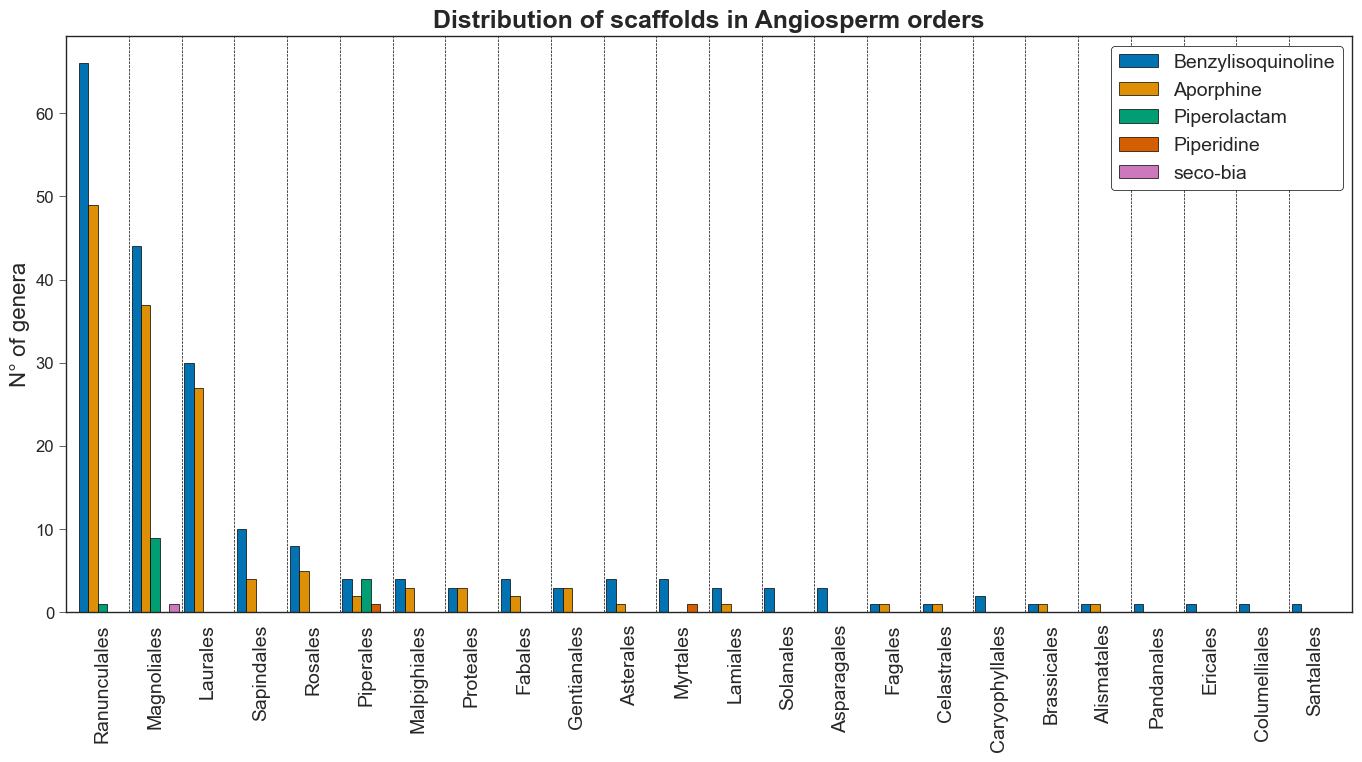

In [18]:
scaff_in_orders = tree_df.groupby('Order')[scaffold_list].sum()
scaff_in_orders = scaff_in_orders[scaff_in_orders.sum(axis=1) != 0] #drop rows with no scaffold

# Sort the bar groups by the total count in descending order
scaff_in_orders = scaff_in_orders.loc[scaff_in_orders.sum(axis=1).sort_values(ascending=False).index]

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white'), sns.set_context("paper", font_scale=2) #style and context
plt.rcParams['font.family'] = 'Arial' #font
colors = sns.color_palette("colorblind", len(scaffold_list)) #color palette

fig, ax = plt.subplots(figsize=(14, 8))
scaff_in_orders.plot(kind='bar', ax=ax, color=colors, width=0.9, edgecolor='black', linewidth=0.5)

ax.set_title('Distribution of scaffolds in Angiosperm orders', fontdict={'fontweight': 'bold', 'fontsize': 18})
ax.set_ylabel('N° of genera', fontsize=16), ax.set_xlabel('') #axis labels
ax.tick_params(axis='x', labelsize=14), ax.tick_params(axis='y', labelsize=12) #tick labels
ax.yaxis.set_ticks_position('left'), ax.yaxis.set_tick_params(width=0.5) #ticks on y axis

#vertical dashed lines to separate bar groups
for i in range(len(scaff_in_orders) - 1):
    ax.axvline(x=i + 0.5, color='black', linestyle°='--', linewidth=0.5)

#capitalize the first letter in the legend for only the first 4 items
handles, labels = ax.get_legend_handles_labels()
labels = [label.capitalize() if i < 4 else label for i, label in enumerate(labels)]
legend = ax.legend(handles, labels, fontsize='14', frameon=True, framealpha=1, edgecolor='black')
legend.get_frame().set_linewidth(0.5)

plt.tight_layout()
plt.show()

iTOL annotation file (full tree)

In [16]:
#create iTOL binary datasets
itol = tree_df[['benzylisoquinoline', 'aporphine', 'piperolactam', 'piperidine', 'seco-bia']] #reorder columns
itol = itol.replace(0, -1) #replace 0 with -1

# Write headers to the iTOL annotation file
output_path = Path('results/phylo_tree/iTOL_scaffolds.txt')
with open(output_path, 'w') as f:
    f.write('DATASET_BINARY\n')
    f.write('SEPARATOR COMMA\n')
    f.write(f'DATASET_LABEL,Scaffold\n') #dataset name
    f.write(f'COLOR,{",".join(["#000000"] * len(itol.columns))}\n') #all black
    f.write(f'FIELD_SHAPES,{",".join([str(i + 1) for i in range(len(itol.columns))])}\n') #shapes from 1 to 5
    f.write(f'FIELD_LABELS,{",".join(itol.columns)}\n') #scaffold names
    f.write('DATA\n')

    # Write each row of the dataframe as a line in the annotation file
    for id, row in itol.iterrows():
        # Convert the row values to strings and join them with commas
        f.write(f'{id},{",".join(map(str, row.values))}\n')
    
    logging.info(f'Annotation file written to {output_path}')

INFO: Annotation file written to results/phylo_tree/iTOL_scaffolds.txt


Create "smaller" tree

In [8]:
#copy of the tree
tree_small = tree

#remove nodes from orders with no scaffold
nodes_to_remove = tree_df[~tree_df['Order'].isin(scaff_in_orders.index)].index.to_list()
for n in nodes_to_remove:
    clade = tree_small.find_any(name=n)
    if clade:
        tree_small.prune(clade)
        logging.info(f"{n} leaf removed from tree...")
    else:
        logging.warning(f"{n} leaf not found in the tree.")

# Save the modified tree to a new file
output_path = tree_file_path.with_name('small_tree.newick')
Phylo.write(tree_small, output_path, "newick")
logging.info(f'Small tree saved as in {output_path}')

INFO: Poales_Poaceae_Neostapfia_colusana leaf removed from tree...
INFO: Poales_Poaceae_Orcuttia_tenuis leaf removed from tree...
INFO: Poales_Poaceae_Orinus_thoroldii leaf removed from tree...
INFO: Poales_Poaceae_Tridentopsis_mutica leaf removed from tree...
INFO: Poales_Poaceae_Gouinia_latifolia leaf removed from tree...
INFO: Poales_Poaceae_Sphenopholis_obtusata leaf removed from tree...
INFO: Poales_Poaceae_Triplasiella_eragrostoides leaf removed from tree...
INFO: Poales_Poaceae_Vaseyochloa_multinervosa leaf removed from tree...
INFO: Poales_Poaceae_Craspedorhachis_africana leaf removed from tree...
INFO: Poales_Poaceae_Farrago_racemosa leaf removed from tree...
INFO: Poales_Poaceae_Perotis_rara leaf removed from tree...
INFO: Poales_Poaceae_Mosdenia_leptostachys leaf removed from tree...
INFO: Poales_Poaceae_Trichoneura_grandiglumis leaf removed from tree...
INFO: Poales_Poaceae_Coleanthus_subtilis leaf removed from tree...
INFO: Poales_Poaceae_Tetrachaete_elionuroides leaf remo